# HW1

In [32]:
import numpy as np
import matplotlib.pyplot as plt

npz_file = np.load('train.npz')
npz_file.files
# npz_file['image'].shape
# npz_file['label'].shape 

['image', 'label']

In [33]:
print("orignal image information:{}".format(npz_file['image'].shape))
print("orignal label information:{}\n".format(npz_file['label'].shape))

x_train, y_train = npz_file['image'].reshape(npz_file['image'].shape[0],-1).T, npz_file['label']
x_train = x_train/255.0
##### make y matrix ####
y_train = np.zeros((npz_file['label'].shape[0],10))
# print(y_train.shape)
for i, label in enumerate(npz_file['label']):
    y_train[i][int(label)] = 1

y_train = y_train.T
print("x training set:", x_train.shape)
print("y training set(label information):", y_train.shape)

look = npz_file['label']
##### shuffle #####
def shuffle(x, y, l=look):
#     print(x.shape[1])
    order = np.arange(x.shape[1])
    np.random.shuffle(order)
    return x[:, order], y[:, order], l[order]


orignal image information:(12000, 28, 28)
orignal label information:(12000,)

x training set: (784, 12000)
y training set(label information): (10, 12000)


In [62]:
my_nn_architecture = [
    {"input_dim": x_train.shape[0], "output_dim": 300, "activation": "relu"},
    {"input_dim": 300, "output_dim": 150, "activation": "relu"},
    {"input_dim": 150, "output_dim": 60, "activation": "relu"},
    {"input_dim": 60, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 10, "activation": "softmax"},
]

# network architecture

def init_layers(nn_architecture, random=True, seed=99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for i, layer in enumerate(nn_architecture):
        layer_i = i + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        if random:
            params_values['W' + str(layer_i)] = 0.1 * np.random.randn(
                layer_output_size, layer_input_size)
            params_values['b' + str(layer_i)] = 0.1 * np.random.randn(
                layer_output_size, 1)
        else:
            params_values['W' + str(layer_i)] = np.zeros((layer_output_size, layer_input_size))
            params_values['b' + str(layer_i)] = np.zeros((layer_output_size, 1))

    return params_values

parameters = init_layers(my_nn_architecture, True)
print(parameters['W1'].shape)

(300, 784)


In [35]:
############################## activation functions ##############################
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x, axis=0)
    return softmax_x 


def relu_backward(dA, Z):
    dZ = np.array(dA)
    dZ[Z<=0] = 0;
    return dZ;

def sigmoid_backward(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

# def softmax_backward():
    

################################### forward ###################################
def forward(x, params, nn_architecture): # architecture {in, out ,activation}
    record = {}
    record['A0'] = x
    for i, layer in enumerate(nn_architecture):
        layer_i = i + 1
        
        if i == 0:
            a = x
        else:
            a = z
        ############ input ###########
        
        W = params['W' + str(layer_i)]
        b = params['b' + str(layer_i)]
        
        h = np.dot(W, a) + b
        # h => 未activate前
        
        if layer["activation"] == "relu":  z = relu(h)
            
        elif layer["activation"] == "softmax": z = softmax(h) # 10 x N
            
        else:
            raise Exception('Only「relu」&「softmax」activation functions to use')
        
        record['Z' + str(i+1)] = h    # activation function前的值 上一層的output
        record['A' + str(i+1)] = z    # activation function後的值 下一層的Input
        
    # 回傳 y_hat,和backward所需數字
    return z, record

################################### forward ###################################

################################### backward ###################################
def backward_propagation(x, y, record, params, nn_architecture): # architecture {in, out ,activation}
    grads = {}
    n = x.shape[1] # number of samples
    
    for i, layer in reversed(list(enumerate(nn_architecture))): # 4,3,2,1,0
        now = i+1
        
        if now != len(nn_architecture):
            dA = pre_dA
            
            #dA  = -np.divide(y, record['A5']) # dA  = -np.divide(y, y_hat)
        #else:
        ############## input #############
        
        if layer["activation"] == "relu":
            dZ = relu_backward(dA, record['Z'+str(now)])
        elif layer["activation"] == "softmax":
            dZ = np.subtract(record['A5'], y) # record['A5']-y # softmax_backward(record['Z'+str(now)])
        else: raise Exception('Only「relu」&「softmax」activation functions to use')
        
        dW = 1/n * np.dot(dZ, record['A'+str(now-1)].T)
        db = 1/n * np.sum(dZ, axis=1, keepdims=True) # 保持row數,array shape(output_dim,1)
        
        pre_dA = np.dot(params['W'+str(now)].T, dZ)
        
        grads['dW'+str(now)] = dW
        grads['db'+str(now)] = db
        
    return grads

################################### backward ###################################

def update_parameters(params, grads, learning_rate):
    for i in range(len(params)//2):
        params['W'+str(i+1)] -= learning_rate * grads['dW'+str(i+1)]
        params['b'+str(i+1)] -= learning_rate * grads['db'+str(i+1)]
    
    return params

################################# Loss & accuracy ################################
def compute_loss(y_hat, y): # shape 10*n
    loss = -np.multiply(y, np.log(y_hat + 1e-7)) # -(y * np.log(y_hat))
    return np.sum(loss)
    
def compute_error_rate(y_hat, y):
    # Y: 10(分類數) x N
    score = 0
    p = np.array((y_hat))
    p[p>0.5] = 1
    p[p<=0.5] = 0
    
    return 1- (np.sum((np.argmax(p, axis=0)==np.argmax(y, axis=0)))/p.shape[1])


In [36]:
import time

def train(X, Y, epochs, learning_rate, nn_architecture, param=None, batch_size=64, INIT='random'):
    # continue training
    if param:
        parameters = param
    else:
        if INIT=='random':
            parameters = init_layers(nn_architecture, random=True)
        else:
            parameters = init_layers(nn_architecture, random=False)
        
    loss_history = []
    error_rate_history = []
    
    for e in range(epochs):
        #X, Y, _ = shuffle(X, Y)
        # SGD
#         if e==epochs/2:
#             learning_rate *= 0.1
        for i in range(0, X.shape[1], batch_size):
            X_mini = X[:,i:i+batch_size]
            Y_mini = Y[:,i:i+batch_size]
            
            ################## forward ################
            pred, temp = forward(X_mini, parameters, nn_architecture)
#             print(X_mini.shape, pred.shape, Y_mini.shape)
            loss = compute_loss(pred, Y_mini) / pred.shape[1]
            error_rate = compute_error_rate(pred, Y_mini)

            ################## backward #########################
            gradients = backward_propagation(pred, Y_mini, temp, parameters, nn_architecture)
            ################## update parameters ################
            parameters = update_parameters(parameters, gradients, learning_rate)
        
        loss_history.append(loss)
        error_rate_history.append(error_rate)
        if e % 25 == 0:
            if e==0:
                print("Epoch {} (lr={}): loss = {}, accuracy = {}% "
                  .format(e, learning_rate, loss, (1-error_rate)*100))
                eStart = time.time()
            else:
                eEnd = time.time()
                print("Epoch {} (lr={}): loss = {}, accuracy = {}% , 25 epochs cost {} secs."
                  .format(e, learning_rate, loss, (1-error_rate)*100, (eEnd - eStart)))
                eStart = time.time()
    
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(error_rate_history)
    plt.title('Training Error Rate')
    plt.xlabel('Number of epochs')
    plt.ylabel('Error Rate')
    plt.show()

        
    return parameters#, cost_history, accuracy_history

## Train (not using shuffle)

### random initializations

Experiment 1 (random initializations, learning_rate=0.01, batch_size=128 epochs=500):

Epoch 0 (lr=0.01): loss = 2.298073272284052, accuracy = 10.416666666666663% 
Epoch 25 (lr=0.01): loss = 1.042512661553043, accuracy = 36.45833333333333% , 25 epochs cost 25.572745084762573 secs.
Epoch 50 (lr=0.01): loss = 0.6208065710492227, accuracy = 62.5% , 25 epochs cost 24.012829065322876 secs.
Epoch 75 (lr=0.01): loss = 0.46517794101022, accuracy = 78.125% , 25 epochs cost 25.40938401222229 secs.
Epoch 100 (lr=0.01): loss = 0.3619737513995805, accuracy = 79.16666666666666% , 25 epochs cost 27.321624517440796 secs.
Epoch 125 (lr=0.01): loss = 0.29579485236882525, accuracy = 81.25% , 25 epochs cost 24.913046836853027 secs.
Epoch 150 (lr=0.01): loss = 0.26387237565349225, accuracy = 82.29166666666666% , 25 epochs cost 25.5023033618927 secs.
Epoch 175 (lr=0.01): loss = 0.24604627677707633, accuracy = 82.29166666666666% , 25 epochs cost 24.695359230041504 secs.
Epoch 200 (lr=0.01): loss = 0.23569624

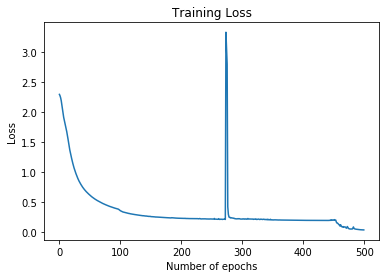

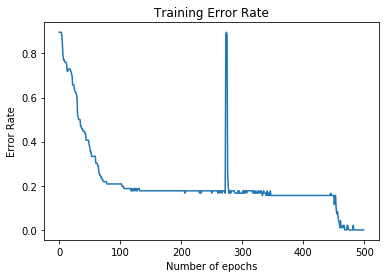

In [37]:
print("Experiment 1 (random initializations, learning_rate=0.01, batch_size=128 epochs=500):\n")
t1_p = train(x_train, y_train, epochs=500, learning_rate=0.01, nn_architecture=my_nn_architecture,
             batch_size=128, INIT='random')

Experiment 2 (random initializations, learning_rate=0.001, batch_size=128 epochs=500):

Epoch 0 (lr=0.001): loss = 0.04215721442011939, accuracy = 100.0% 
Epoch 25 (lr=0.001): loss = 0.040579338577264354, accuracy = 100.0% , 25 epochs cost 23.152751684188843 secs.
Epoch 50 (lr=0.001): loss = 0.03943287268302605, accuracy = 100.0% , 25 epochs cost 23.10923981666565 secs.
Epoch 75 (lr=0.001): loss = 0.03845717757794081, accuracy = 100.0% , 25 epochs cost 22.853460788726807 secs.
Epoch 100 (lr=0.001): loss = 0.03758960570550915, accuracy = 100.0% , 25 epochs cost 23.079293489456177 secs.
Epoch 125 (lr=0.001): loss = 0.03670800674709511, accuracy = 100.0% , 25 epochs cost 23.038689374923706 secs.
Epoch 150 (lr=0.001): loss = 0.0359381107428498, accuracy = 100.0% , 25 epochs cost 23.52113437652588 secs.
Epoch 175 (lr=0.001): loss = 0.03520375182709134, accuracy = 100.0% , 25 epochs cost 22.88882875442505 secs.
Epoch 200 (lr=0.001): loss = 0.03449729283914861, accuracy = 100.0% , 25 epochs c

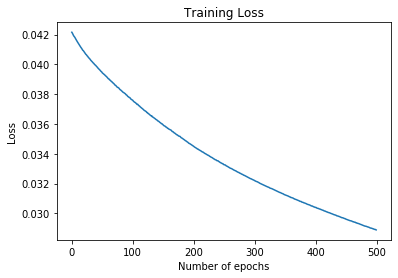

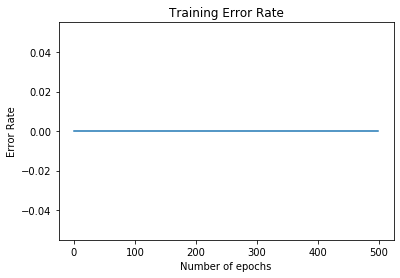

In [38]:
print("Experiment 2 (random initializations, learning_rate=0.001, batch_size=128 epochs=500):\n")
t2_p = train(x_train, y_train, epochs=500, learning_rate=0.001, nn_architecture=my_nn_architecture,
             param=t1_p, batch_size=128, INIT='random')

### zero initializations

Experiment 3 (zero initializations, learning_rate=0.01, batch_size=128 epochs=500):

Epoch 0 (lr=0.01): loss = 2.299308691827082, accuracy = 10.416666666666663% 
Epoch 25 (lr=0.01): loss = 2.278033191801275, accuracy = 10.416666666666663% , 25 epochs cost 20.434404850006104 secs.
Epoch 50 (lr=0.01): loss = 2.277232843163284, accuracy = 10.416666666666663% , 25 epochs cost 21.900221824645996 secs.
Epoch 75 (lr=0.01): loss = 2.277204238006114, accuracy = 10.416666666666663% , 25 epochs cost 20.65783381462097 secs.
Epoch 100 (lr=0.01): loss = 2.27720488188721, accuracy = 10.416666666666663% , 25 epochs cost 20.40945291519165 secs.
Epoch 125 (lr=0.01): loss = 2.277205163063776, accuracy = 10.416666666666663% , 25 epochs cost 20.638818740844727 secs.
Epoch 150 (lr=0.01): loss = 2.277205185908712, accuracy = 10.416666666666663% , 25 epochs cost 20.744534969329834 secs.
Epoch 175 (lr=0.01): loss = 2.2772051815619, accuracy = 10.416666666666663% , 25 epochs cost 20.634923934936523 secs.
Epoch 

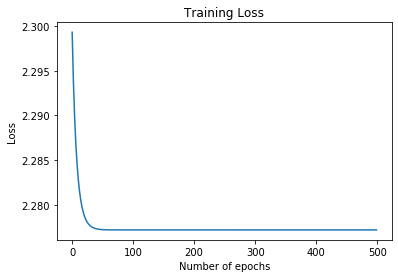

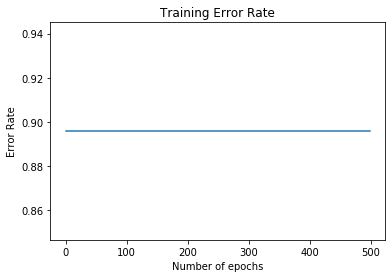

In [39]:
# learning_rate = 0.01
print("Experiment 3 (zero initializations, learning_rate=0.01, batch_size=128 epochs=500):\n")
t3_p = train(x_train, y_train, epochs=500, learning_rate=0.01, nn_architecture=my_nn_architecture,
             batch_size=128, INIT='zero')

In [40]:
# learning_rate = 0.1, batch_size=256
# t4_p = train(x_train, y_train, epochs=500, learning_rate=0.1, nn_architecture=my_nn_architecture,
#              batch_size=256, INIT='zero')

## Test

In [41]:
def test(X, Y, nn_architecture, param):
    
    pred, temp = forward(X, param, nn_architecture)
    
    loss = compute_loss(pred, Y) / pred.shape[1]
    error_rate = compute_error_rate(pred, Y)
#     accuracy = compute_accuracy(pred, Y)
    print("Test: loss = {}, accuracy = {}%".format(loss, (1-error_rate)*100))
    
    return pred

In [42]:
test_file = np.load('test.npz')

x_test, y_test = test_file['image'].reshape(test_file['image'].shape[0],-1).T, test_file['label']
x_test = x_test/255.0

##### make y matrix ####
y_test = np.zeros((test_file['label'].shape[0],10))
# print(y_train.shape)
for i, label in enumerate(test_file['label']):
    y_test[i][int(label)] = 1

y_test = y_test.T
print('\n================== Test ==================')
print("\nx test set:", x_test.shape)
print("y test set(label information):", y_test.shape)

print("\nRandom initializations after 500 epochs(lr=0.01):")
test_result1 = test(x_test, y_test, my_nn_architecture, t1_p)
print("\nRandom initializations after 1000 epochs(lr=0.001):")
test_result2 = test(x_test, y_test, my_nn_architecture, t2_p)

print("\nZero initializations after 500 epochs(lr=0.01):")
test_result3 = test(x_test, y_test, my_nn_architecture, t3_p)


================== Test ==================

x test set: (784, 5768)
y test set(label information): (10, 5768)

Random initializations after 500 epochs(lr=0.01):
Test: loss = 0.7069757357490515, accuracy = 88.17614424410542%

Random initializations after 1000 epochs(lr=0.001):
Test: loss = 0.7069757357490515, accuracy = 88.17614424410542%

Zero initializations after 500 epochs(lr=0.01):
Test: loss = 2.2918677921078046, accuracy = 11.51178918169209%


### Distributions of Latent Features


============ Distributions of Latent Features ============
20 Epochs training:

Epoch 0 (lr=0.01): loss = 2.298073272284052, accuracy = 10.416666666666663% 


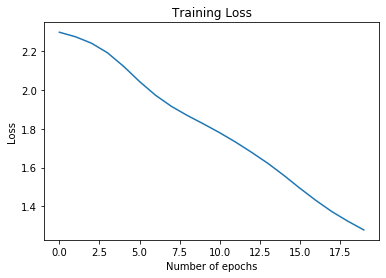

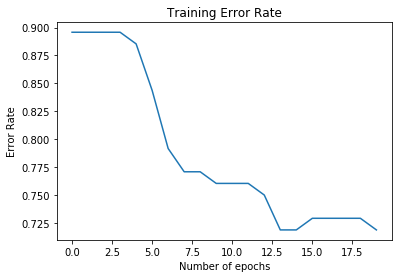

80 Epochs training:

Epoch 0 (lr=0.01): loss = 2.298073272284052, accuracy = 10.416666666666663% 
Epoch 25 (lr=0.01): loss = 1.042512661553043, accuracy = 36.45833333333333% , 25 epochs cost 22.52428960800171 secs.
Epoch 50 (lr=0.01): loss = 0.6208065710492227, accuracy = 62.5% , 25 epochs cost 22.952264308929443 secs.
Epoch 75 (lr=0.01): loss = 0.46517794101022, accuracy = 78.125% , 25 epochs cost 22.256015062332153 secs.


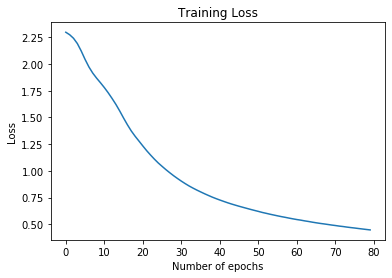

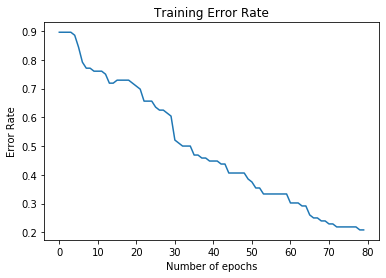

In [43]:
print('\n============ Distributions of Latent Features ============')
print('20 Epochs training:\n')
e20_p = train(x_train, y_train, epochs=20, learning_rate=0.01, nn_architecture=my_nn_architecture,
             batch_size=128, INIT='random')
print('80 Epochs training:\n')
e80_p = train(x_train, y_train, epochs=80, learning_rate=0.01, nn_architecture=my_nn_architecture,
             batch_size=128, INIT='random')

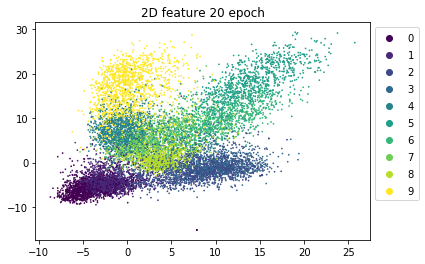

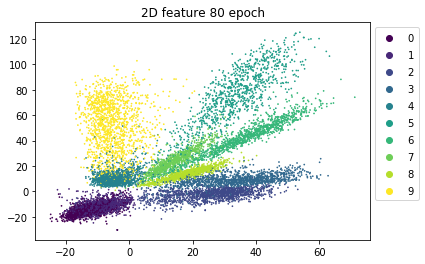

In [54]:
e20_y_hat, e20_record = forward(x_train, e20_p, my_nn_architecture)
e80_y_hat, e80_record = forward(x_train, e80_p, my_nn_architecture)

def convert_class(y_hat):
    _class = np.array((y_hat))
    _class[_class>0.5] = 1
    _class[_class<=0.5] = 0
    return np.argmax(_class, axis=0)

"""
# np.argmax(y_train, axis=0)

e20_class = convert_class(e20_y_hat)
#  print(e20_class)

e80_class = convert_class(e80_y_hat)
# print(e80_class)
"""

l = np.argmax(y_train, axis=0)

plt.title('2D feature 20 epoch')
scatter=plt.scatter(e20_record['Z4'][0,:], e20_record['Z4'][1,:], s=0.5, c=l)
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 1))
plt.show()

plt.title('2D feature 80 epoch')
scatter=plt.scatter(e80_record['Z4'][0,:], e80_record['Z4'][1,:], s=0.5, c=l)
plt.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 1))
plt.show()

In [55]:
# print(test_result2.shape, y_test.shape)
# print(np.array_equal(test_file['label'], convert_class(y_test)))
# print(convert_class(y_test))
# print(convert_class(test_result2))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(convert_class(y_test), convert_class(test_result2))
# print(cm)

test(x_test, y_test, my_nn_architecture, t2_p)
import pandas as pd
pd.DataFrame(cm)

Test: loss = 0.7069757357490515, accuracy = 88.17614424410542%


,0,1,2,3,4,5,6,7,8,9
0,628,31,0,0,1,0,0,2,2,0
1,58,599,1,2,0,0,0,0,0,1
2,5,11,516,52,0,0,0,0,0,0
3,2,5,68,483,0,0,3,0,39,0
4,26,4,0,1,540,0,9,24,19,28
5,0,0,0,0,12,360,1,33,1,0
6,0,0,0,0,0,1,464,27,10,0
7,0,1,0,0,8,48,48,333,9,2
8,1,0,0,2,2,0,20,7,540,0
9,1,0,0,1,35,4,1,10,3,623


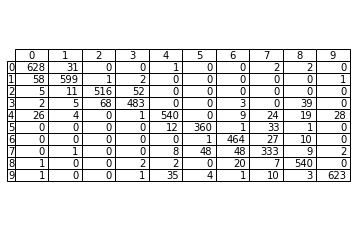

In [57]:
import pandas as pd

df = pd.DataFrame(cm)

from pandas.plotting import table 

ax = plt.subplot()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table(ax, df, loc='center')
plt.savefig('confusion_matrix.png')